In [53]:
############################
# 1) Install Dependencies #
############################
!pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade transformers datasets evaluate librosa seaborn
!pip install bitsandbytes
!pip install pydub
!pip install praat-parselmouth



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [2]:

############################
# 2) Import Libraries     #
############################
import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:true"
import requests
import shutil
from zipfile import ZipFile
import torch
import librosa
import datasets
import evaluate
import pandas as pd
import scipy.signal
import torch.nn as nn
import parselmouth
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from parselmouth.praat import call
from tqdm import tqdm
from datasets import load_from_disk, Dataset, DatasetDict, concatenate_datasets
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    TrainingArguments,
    Trainer,
    get_scheduler
)

from torch.nn.utils.rnn import pad_sequence
from bitsandbytes.optim import Adam8bit
from sklearn.metrics import classification_report, confusion_matrix
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
############################
# 3) Check GPU & Versions #
############################
print("Torch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("GPU available?", torch.cuda.is_available())
print("Using device:", device)
!nvidia-smi


Torch version: 2.6.0+cu118
GPU available? True
Using device: cuda
Wed Feb 26 16:07:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             45W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |      

## Data acquisition

In [55]:
urls = [
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc2.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc3.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc4.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc5.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc6.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc7.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc8.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc9.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc10.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc11.zip"
]

# 2) SET UP FOLDERS
# Create root directories for your final data
os.makedirs("Healthy", exist_ok=True)
os.makedirs("MCI", exist_ok=True)
os.makedirs("AD", exist_ok=True)

# Create a temporary folder for extracted files
temp_folder = "tmp_extracted"
os.makedirs(temp_folder, exist_ok=True)

# 3) DOWNLOAD AND EXTRACT EACH ZIP
for i, url in enumerate(urls):
    zip_filename = f"downloaded_{i}.zip"   # A local name to store the downloaded file

    # Download the file
    print(f"Downloading from {url}...")
    response = requests.get(url)
    with open(zip_filename, "wb") as f:
        f.write(response.content)
    print(f"Saved {zip_filename}")

    # Extract all contents into the temp_folder
    print(f"Extracting {zip_filename}...")
    with ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(temp_folder)

    # Optionally delete the ZIP file after extraction to save space
    os.remove(zip_filename)

temp_folder = "tmp_extracted"  # your temporary extraction folder



# 4) MOVE FILES INTO THE RIGHT FOLDERS (WITH MP3 TO WAV CONVERSION)
for root, dirs, files in os.walk(temp_folder):
    for filename in files:
        full_path = os.path.join(root, filename)
        # Convert MP3 to WAV if needed
        if filename.endswith(".mp3"):
            wav_filename = filename.replace(".mp3", ".wav")
            wav_path = os.path.join(root, wav_filename)
            # Convert MP3 to WAV
            audio = AudioSegment.from_mp3(full_path)
            audio.export(wav_path, format="wav")
            # Remove the original MP3
            os.remove(full_path)
            # Update full_path to the new WAV file
            full_path = wav_path
            filename = wav_filename
        # Move to corresponding folder
        if filename.startswith("AD"):
            shutil.move(full_path, os.path.join("AD", filename))
        elif filename.startswith("MCI"):
            shutil.move(full_path, os.path.join("MCI", filename))
        elif filename.startswith("HC"):
            shutil.move(full_path, os.path.join("Healthy", filename))
        else:
            print(f"File '{filename}' doesn't match AD/MCI/HC. Skipping or placing it elsewhere.")
print("MP3 conversion and file moving completed.")
# 5) CLEAN UP
shutil.rmtree(temp_folder, ignore_errors=True)
print("Temporary folder removed.")


Saved downloaded_0.zip
Extracting downloaded_0.zip...
Saved downloaded_1.zip
Extracting downloaded_1.zip...
Saved downloaded_2.zip
Extracting downloaded_2.zip...
Saved downloaded_3.zip
Extracting downloaded_3.zip...
Saved downloaded_4.zip
Extracting downloaded_4.zip...
Saved downloaded_5.zip
Extracting downloaded_5.zip...
Saved downloaded_6.zip
Extracting downloaded_6.zip...
Saved downloaded_7.zip
Extracting downloaded_7.zip...
Saved downloaded_8.zip
Extracting downloaded_8.zip...
Saved downloaded_9.zip
Extracting downloaded_9.zip...
MP3 conversion and file moving completed.
Temporary folder removed.


In [6]:
# model definition
from transformers.modeling_outputs import SequenceClassifierOutput

class Wav2Vec2ProsodicClassifier(nn.Module):
    def __init__(self, base_model, num_labels, prosodic_dim=7):
        super().__init__()
        self.wav2vec2 = base_model  # Wav2Vec2 model
        self.prosody_mlp = nn.Sequential(
            nn.Linear(prosodic_dim, 32),  # Increase intermediate representation
            nn.ReLU(),
            nn.Linear(32, 16),  # Final projection before concatenation
            nn.ReLU()
        )

        hidden_size = self.wav2vec2.config.hidden_size
        self.fc_combined = nn.Linear(hidden_size + 16, num_labels)

        self.dropout = nn.Dropout(0.1)  # Regularization

    def forward(self, input_values, prosodic_features, attention_mask=None, labels=None, **kwargs):
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        wav_embeddings = outputs.hidden_states[-1].mean(dim=1)  # (Batch, hidden_size)

        # Pass prosodic features through MLP
        prosodic_embeddings = self.prosody_mlp(prosodic_features)  # (Batch, 16)

        # Concatenate both feature sets
        combined_features = torch.cat((wav_embeddings, prosodic_embeddings), dim=-1)
        combined_features = self.dropout(combined_features)

        logits = self.fc_combined(combined_features)  # (Batch, num_labels)
        if logits.dim() == 1:
          logits = logits.unsqueeze(0)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )
    def gradient_checkpointing_enable(self):
        self.wav2vec2.gradient_checkpointing_enable()
model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-spanish"
processor = Wav2Vec2Processor.from_pretrained(model_name)
base_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)



Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-spanish and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
## Misc definitions
ROOT_DIR = os.getcwd()
DATASET_PATH = ROOT_DIR  # Root folder where audio files are stored
OUTPUT_PATH = os.path.join(ROOT_DIR, "ProcessedFiles")
os.makedirs(OUTPUT_PATH, exist_ok=True)
LABEL_MAP = {"Healthy": 0, "MCI": 1, "AD": 2}

classes = ["HC", "MCI", "AD"]
#Extracted features
features = [
        "num_pauses",
        "total_pause_duration",
        "phonation_time",
        "speech_rate",
        "mean_intensity"
    ]
## Definitions needed for the weighted cross entropy loss function
#Sample weights calculations to compensate for imbalancedd dataset
num_samples_per_class = {
    0: 197,  # Healthy (HC)
    1: 90,   # MCI
    2: 74    # AD
}
# Compute original class weights
total_samples = sum(num_samples_per_class.values())
num_classes = len(num_samples_per_class)
class_weights = {cls: total_samples / (num_classes * count) for cls, count in num_samples_per_class.items()}
#  Manually increase MCI weight
class_weights[1] *= 2  # Double MCI weight
class_weights[2] *= 2  # Double AD weight
#  Normalize class weights (to prevent excessive imbalance)
max_weight = max(class_weights.values())
class_weights = {cls: weight / max_weight for cls, weight in class_weights.items()}
# Convert to PyTorch tensor
device = "cuda" if torch.cuda.is_available() else "cpu"
weights_tensor = torch.tensor([class_weights[0], class_weights[1], class_weights[2]], dtype=torch.float).to(device)
# Use in CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)



In [48]:
## Functions definitions

def load_audio(file_path, target_sr=16000):
    audio, sr = librosa.load(file_path, sr=target_sr)
    return np.array(audio, dtype=np.float32), sr  # Ensure float32 output

def preprocess_function(example):
    # Wav2Vec2 processing
    inputs = processor(example["audio"]["array"], sampling_rate=example["audio"]["sampling_rate"], return_tensors="pt")
    # Build prosodic features from the 7 standardized columns you added:
    #   Age, duration, num_pauses, total_pause_duration, phonation_time, speech_rate, mean_intensity
    # They’re already in the HF dataset as top-level keys on `example`. For instance:
    # example["Age"], example["duration"], etc.
    numeric_cols = ["Age", "duration", "num_pauses", "total_pause_duration", "phonation_time", "speech_rate", "mean_intensity"]
    feats = [example[col] for col in numeric_cols]

    inputs["prosodic_features"] = torch.tensor(feats, dtype=torch.float32)
    inputs["label"] = example["label"]
    return inputs

def chunk_audio(example, max_length=16000*100):  # 60 seconds max
    audio = example["audio"]
    if len(audio) > max_length:
        example["audio"] = audio[:max_length]
    return preprocess_function(example)

# Function to compute audio duration
def compute_audio_length(file_path):
    y, sr = librosa.load(file_path, sr=None)  # Load audio
    return len(y) / sr  # Compute duration in seconds

# Extract class labels from file names
def extract_class(file_path):
    filename = file_path.split("/")[-1]  # Extract filename
    if filename.startswith("HC"):
        return "HC"  # Healthy
    elif filename.startswith("MCI"):
        return "MCI"  # Mild Cognitive Impairment
    elif filename.startswith("AD"):
        return "AD"  # Alzheimer's
    return "Unknown"


def extract_prosodic_features(audio_path):
    sound = parselmouth.Sound(audio_path)
    duration_sec = sound.duration

    # ------------------------------------------------------
    # 1) Phonation Time, Pauses, Voice Breaks
    # ------------------------------------------------------
    # Compute intensity (Praat method)
    intensity = sound.to_intensity()
    # **1) Dynamic Silence Threshold**
    # Use median intensity of voiced regions instead of a fixed 20 dB threshold
    mean_intensity = call(intensity, "Get mean", 0, 0)
    min_silence_db = mean_intensity - 15  # Adaptive threshold (-15 dB from avg.)
    # **2) Pause Detection Logic**
    min_pause_duration = 0.15  # Ignore pauses shorter than 150 ms
    time_step = 0.01  # Analysis step size (10 ms)
    silence_intervals = []
    is_silent = False
    start_silence = None

    # Iterate through intensity frames to detect pauses
    for t in np.arange(0, duration_sec, time_step):
        current_db = intensity.get_value(time=t) or 0.0

        if current_db < min_silence_db:
            if not is_silent:
                is_silent = True
                start_silence = t  # Pause starts
        else:
            if is_silent:
                end_silence = t  # Pause ends
                pause_duration = end_silence - start_silence

                if pause_duration >= min_pause_duration:
                    silence_intervals.append((start_silence, end_silence))

                is_silent = False

    # **If the file ends in silence**
    if is_silent and (duration_sec - start_silence) >= min_pause_duration:
        silence_intervals.append((start_silence, duration_sec))

    # **3) Compute Final Pause Features**
    num_pauses = len(silence_intervals)  # Number of pauses
    total_pause_duration = np.sum([end - start for start, end in silence_intervals])  # Total pause time
    phonation_time = duration_sec - total_pause_duration  # Phonated (spoken) time

    # ------------------------------------------------------
    # 2) Speech Rate
    # ------------------------------------------------------
    known_syllable_count = 126
    speech_rate = known_syllable_count / phonation_time if phonation_time > 0 else 0.0

    # ------------------------------------------------------
    # 3) Speech Energy & Intensity
    # ------------------------------------------------------
    mean_intensity = call(intensity, "Get mean", 0, 0)
    stdev_intensity = call(intensity, "Get standard deviation", 0, 0)

    # Approximate LTAS:
    spectrum = sound.to_spectrum()
    n_bands = 100
    freq_step = 5000 / n_bands
    band_energies = []
    for b in range(n_bands):
        low_freq = b * freq_step
        hi_freq = (b + 1) * freq_step
        band_energy = call(spectrum, "Get band energy", low_freq, hi_freq)
        band_energies.append(band_energy)
    ltas_mean = np.mean(band_energies)
    ltas_std = np.std(band_energies)

    # Collect features into a list (or tuple) in a consistent order:
    feature_values = [
        num_pauses,
        total_pause_duration,
        phonation_time,
        speech_rate,
        mean_intensity,
        #stdev_intensity
        #ltas_mean,
        #ltas_std,
    ]

    # Convert to a NumPy array (float32 for compactness/speed)
    return np.array(feature_values, dtype=np.float32)


''' def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    report = classification_report(labels, predictions, target_names=["Healthy", "MCI", "AD"], output_dict=True)

    print("Classification Report:\n", classification_report(labels, predictions, target_names=["Healthy", "MCI", "AD"]))

    return {
        "accuracy": report["accuracy"],
        "f1_macro": report["macro avg"]["f1-score"],
        "f1_healthy": report["Healthy"]["f1-score"],
        "f1_mci": report["MCI"]["f1-score"],
        "f1_ad": report["AD"]["f1-score"],
    } '''
from sklearn.metrics import confusion_matrix

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    # Ensure predictions and labels are NumPy arrays
    preds = torch.argmax(torch.tensor(logits), dim=-1).numpy()

    # Compute classification report
    report = classification_report(labels, preds, target_names=["Healthy", "MCI", "AD"], output_dict=True)

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Extract TP, FP, TN, FN per class
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (TP + FP + FN)

    # Compute Specificity (TNR) and Negative Predictive Value (NPV) per class
    specificity = TN / (TN + FP + 1e-10)  # True Negative Rate
    npv = TN / (TN + FN + 1e-10)  # Negative Predictive Value

    # Store per-class and macro-average results
    results = {
        "accuracy": report["accuracy"],
        "macro_f1": report["macro avg"]["f1-score"],
        "macro_precision": report["macro avg"]["precision"],
        "macro_recall": report["macro avg"]["recall"],
        "macro_specificity": np.mean(specificity),
        "macro_npv": np.mean(npv),
        "f1_healthy": report["Healthy"]["f1-score"],
        "f1_mci": report["MCI"]["f1-score"],
        "f1_ad": report["AD"]["f1-score"],
        "specificity_healthy": specificity[0],
        "specificity_mci": specificity[1],
        "specificity_ad": specificity[2],
        "npv_healthy": npv[0],
        "npv_mci": npv[1],
        "npv_ad": npv[2]
    }

    return results


def data_collator_fn(features):
    waveforms = [torch.tensor(f["audio"]["array"]) for f in features]
    prosodic_features = torch.stack([
        torch.tensor(f["prosodic_features"], dtype=torch.float) for f in features
    ])  # Now each prosodic_features is converted to a tensor
    labels = torch.tensor([f["label"] for f in features])

    input_values = pad_sequence(waveforms, batch_first=True, padding_value=0)

    inputs = processor(
        input_values.numpy(),
        sampling_rate=16000,
        padding=True,
        return_tensors="pt"
    )

    inputs["labels"] = labels
    inputs["prosodic_features"] = prosodic_features  # Add prosodic features
    return inputs


In [49]:

audio_files = []
labels = []

for category in LABEL_MAP.keys():
    category_path = os.path.join(DATASET_PATH, category)
    if not os.path.exists(category_path):
        continue
    for file in os.listdir(category_path):
        if file.endswith(".wav"):
            audio_files.append(os.path.join(category_path, file))
            labels.append(LABEL_MAP[category])

data_df = pd.DataFrame({"file_path": audio_files, "label": labels})



## Feature Engineering

In [50]:
data_df["duration"] = data_df["file_path"].apply(compute_audio_length)
data_df["class"] = data_df["file_path"].apply(extract_class)
data_df.head()

,file_path,label,duration,class
0,/content/Healthy/HC-W-70-220.wav,0,24.216281,HC
1,/content/Healthy/HC-W-61-212.wav,0,33.386508,HC
2,/content/Healthy/HC-W-74-350.wav,0,42.501224,HC
3,/content/Healthy/HC-W-78-216.wav,0,48.869796,HC
4,/content/Healthy/HC-W-81-172.wav,0,35.553810,HC


In [51]:
#Extract sex and age from files' name
def extract_sex_age(file_path):
    try:
        filename = file_path.split("/")[-1]  # Get filename from path
        parts = filename.replace(".wav", "").split("-")  # Split by '-'

        if len(parts) >= 3:  # Ensure we have at least "Class-Sex-Age"
            sex = parts[1]  # Extract sex (M or W)
            age = int(parts[2])  # Convert age to integer
            return sex, age
    except Exception as e:
        print(f"Error extracting from {file_path}: {e}")

    return None, None  # Default if extraction fails

# Apply function to extract Sex and Age
data_df["Sex"], data_df["Age"] = zip(*data_df["file_path"].apply(extract_sex_age))



In [52]:

#data_df = pd.concat([data_df, age_sex_df], axis=1)
data_df = data_df.loc[:, ~data_df.columns.duplicated()]
data_df.tail()

,file_path,label,duration,class,Sex,Age
356,/content/AD/AD-W-80-310.wav,2,43.157800,AD,W,80
357,/content/AD/AD-W-62-45.wav,2,59.477914,AD,W,62
358,/content/AD/AD-W-78-223.wav,2,36.617506,AD,W,78
359,/content/AD/AD-M-67-285.wav,2,36.818141,AD,M,67
360,/content/AD/AD-W-72-226.wav,2,25.374218,AD,W,72


In [53]:
mean_values = data_df.groupby("class")["Age"].mean()
std_values = data_df.groupby("class")["Age"].std()

print(mean_values)
print(std_values)

class
AD     79.486486
HC     75.461929
MCI    79.511111
Name: Age, dtype: float64
class
AD     7.921262
HC     7.951692
MCI    9.594292
Name: Age, dtype: float64


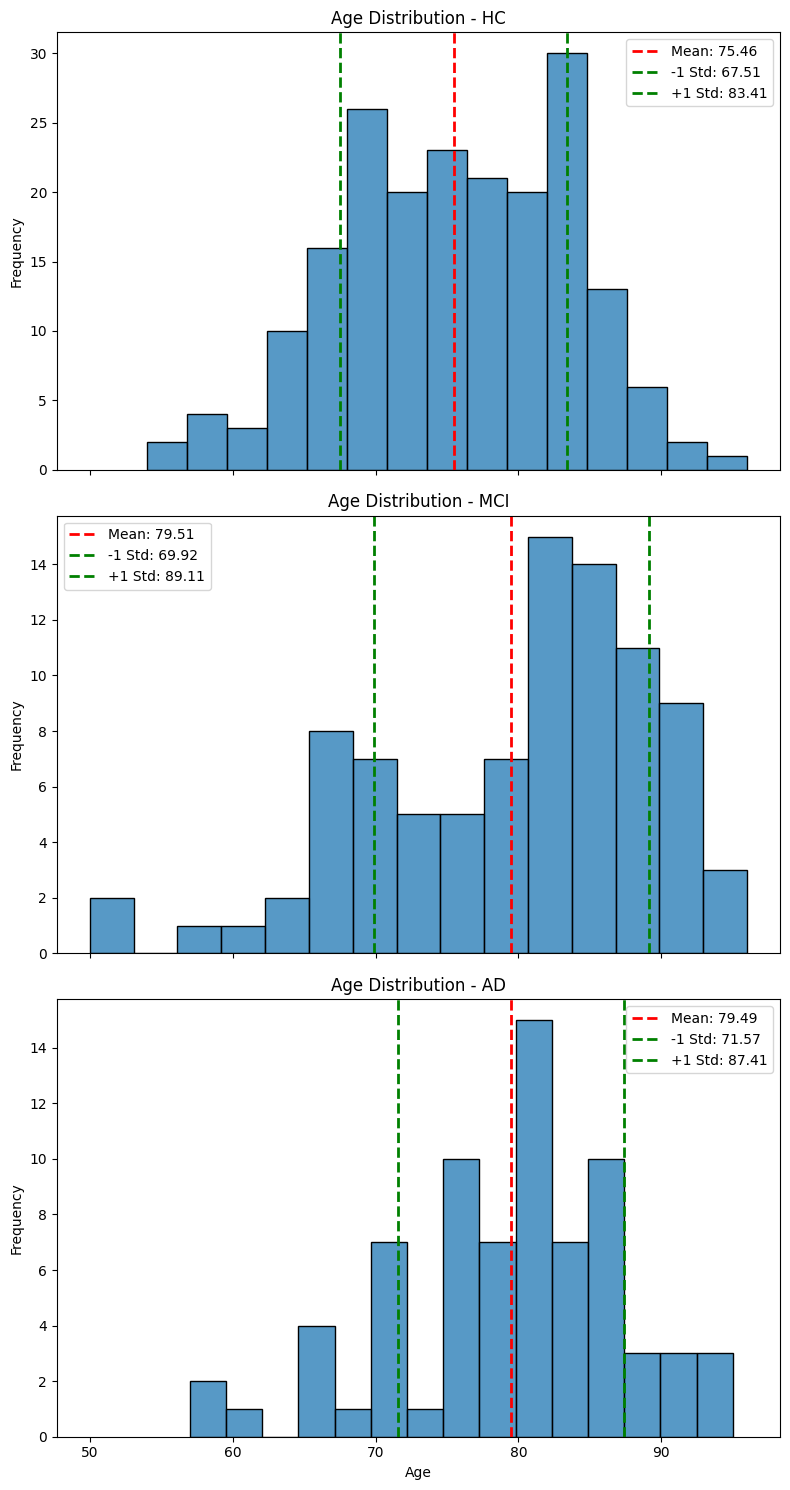

In [54]:

plt.style.use("default")

# Get unique classes
fig, axes = plt.subplots(len(classes), 1, figsize=(8, 5 * len(classes)), sharex=True)

for i, cls in enumerate(classes):
    ax = axes[i] if len(classes) > 1 else axes  # Handle single-class case
    subset = data_df[data_df["class"] == cls]["Age"]

    sns.histplot(subset, bins=15, kde=False, ax=ax)

    # Correct way to access values
    mean_age = mean_values[cls]
    std_age = std_values[cls]

    # Plot mean and standard deviation lines
    ax.axvline(mean_age, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_age:.2f}")
    ax.axvline(mean_age - std_age, color='g', linestyle='dashed', linewidth=2, label=f'-1 Std: {mean_age - std_age:.2f}')
    ax.axvline(mean_age + std_age, color='g', linestyle='dashed', linewidth=2, label=f'+1 Std: {mean_age + std_age:.2f}')

    # Titles and labels
    ax.set_title(f"Age Distribution - {cls}")
    ax.set_xlabel("Age")
    ax.set_ylabel("Frequency")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [55]:
# Count the number of men (M) and women (W)
total_men = (data_df["Sex"] == "M").sum()
total_women = (data_df["Sex"] == "W").sum()

print(f"Total number of men: {total_men}")
print(f"Total number of women: {total_women}")


most_prevalent_sex = data_df.groupby("class")["Sex"].agg(lambda x: x.mode()[0])
print("Most prevalent sex per class")
print(most_prevalent_sex)

Total number of men: 113
Total number of women: 248
Most prevalent sex per class
class
AD     W
HC     W
MCI    W
Name: Sex, dtype: object


Mean Duration: 48.17 seconds
Standard Deviation: 24.93 seconds


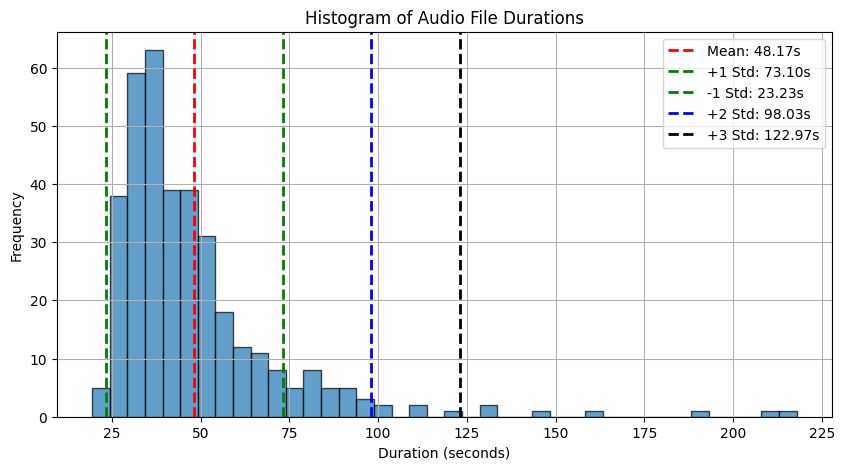

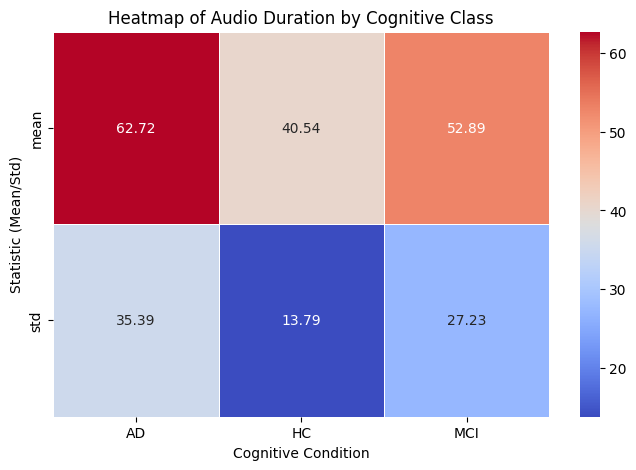

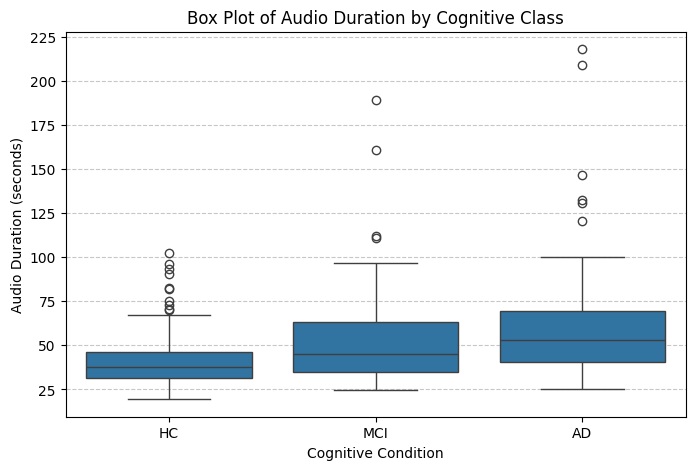

In [56]:

# Extract prosodic features
prosodic_features = data_df["file_path"].apply(extract_prosodic_features)
# Convert the extracted feature arrays into separate columns
prosodic_df = pd.DataFrame(prosodic_features.tolist(), columns=features)
# Merge the extracted features with the main DataFrame
data_df = pd.concat([data_df, prosodic_df], axis=1)
# Drop duplicate columns (keep only one occurrence of each feature)
data_df = data_df.loc[:, ~data_df.columns.duplicated()]
data_df.head()

# Compute statistics
mean_duration = data_df["duration"].mean()
std_duration = data_df["duration"].std()
mean_values = data_df.groupby("class")[features].mean()
std_values = data_df.groupby("class")[features].std()


# Print statistics
print(f"Mean Duration: {mean_duration:.2f} seconds")
print(f"Standard Deviation: {std_duration:.2f} seconds")

# Plot a single histogram for all durations
plt.figure(figsize=(10, 5))
plt.hist(data_df["duration"], bins=40, edgecolor="black", alpha=0.7)
plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_duration:.2f}s")
plt.axvline(mean_duration + std_duration, color='green', linestyle='dashed', linewidth=2, label=f"+1 Std: {mean_duration + std_duration:.2f}s")
plt.axvline(mean_duration - std_duration, color='green', linestyle='dashed', linewidth=2, label=f"-1 Std: {mean_duration - std_duration:.2f}s")
plt.axvline(mean_duration + 2*std_duration, color='blue', linestyle='dashed', linewidth=2, label=f"+2 Std: {mean_duration + 2*std_duration:.2f}s")
plt.axvline(mean_duration + 3*std_duration, color='black', linestyle='dashed', linewidth=2, label=f"+3 Std: {mean_duration + 3*std_duration:.2f}s")

plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Histogram of Audio File Durations")
plt.legend()
plt.grid(True)
plt.show()

# Compute mean and std deviation of duration per class
heatmap_data = data_df.groupby("class")["duration"].agg(["mean", "std"]).reset_index()
# Convert to a matrix format suitable for a heatmap
heatmap_matrix = heatmap_data.set_index("class").T

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Heatmap of Audio Duration by Cognitive Class")
plt.xlabel("Cognitive Condition")
plt.ylabel("Statistic (Mean/Std)")
plt.show()


## Box plot
# Create a box plot for audio duration per class
plt.figure(figsize=(8, 5))
sns.boxplot(x="class", y="duration", data=data_df)
# Formatting the plot
plt.title("Box Plot of Audio Duration by Cognitive Class")
plt.xlabel("Cognitive Condition")
plt.ylabel("Audio Duration (seconds)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


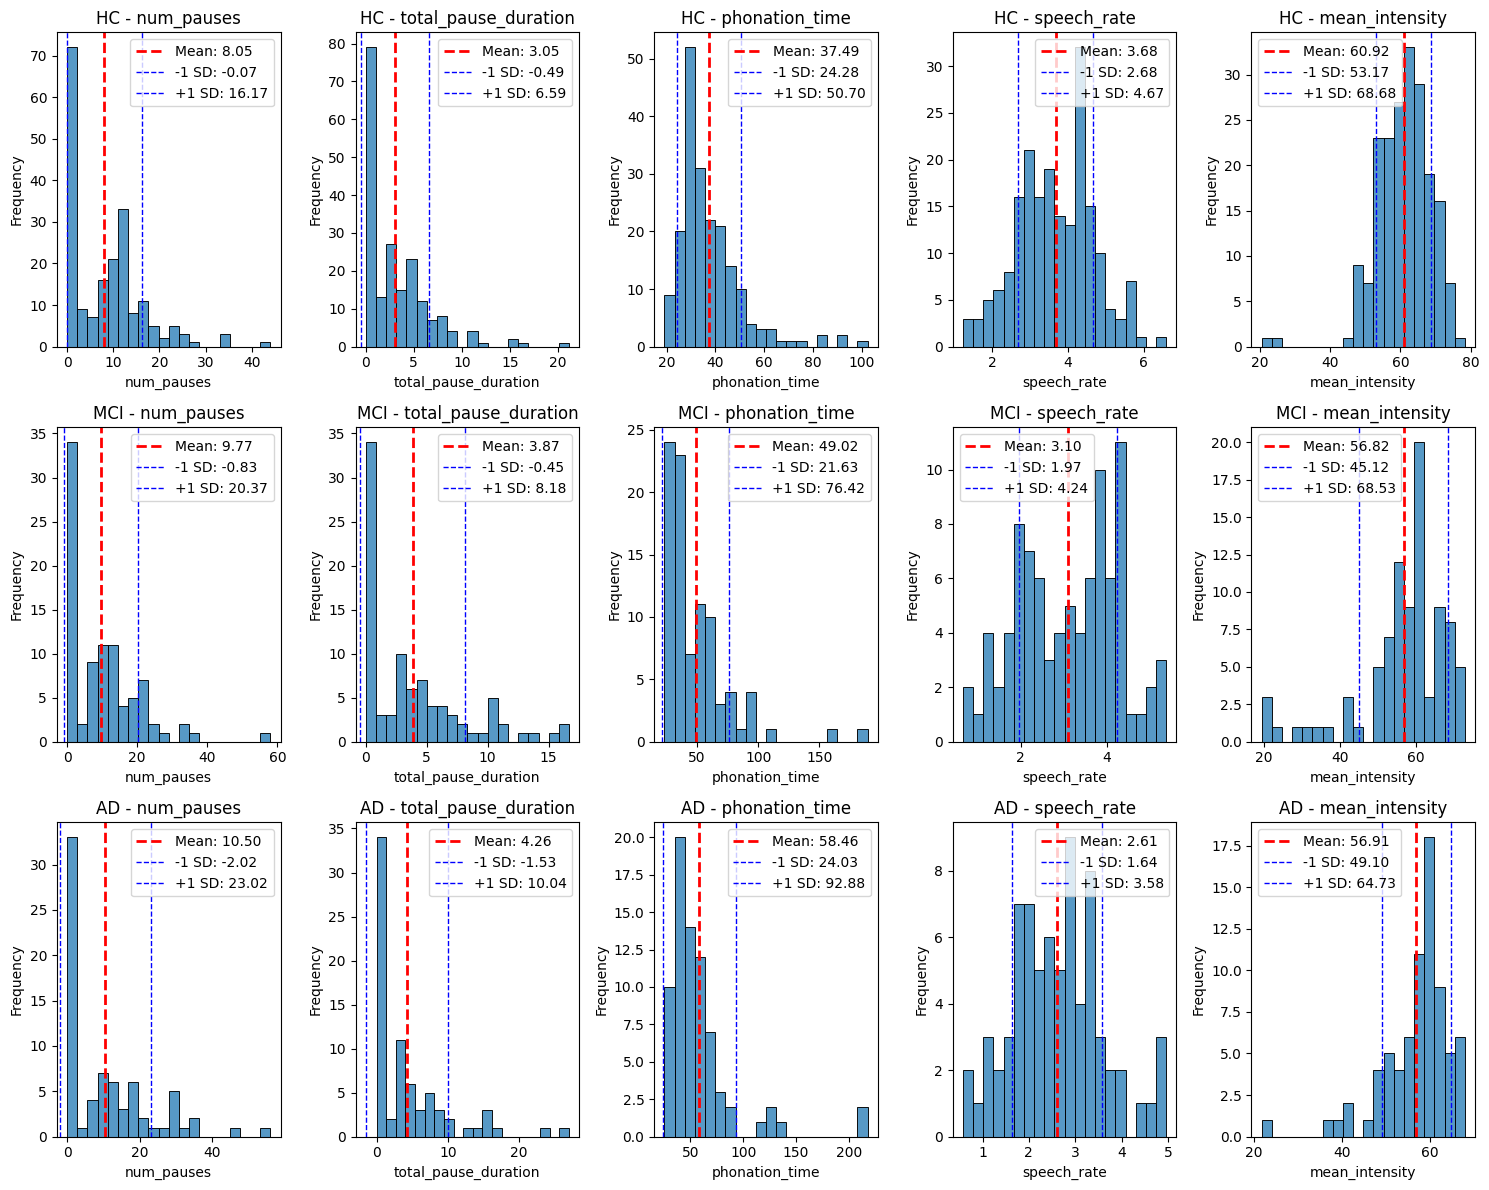


Mean and Standard Deviation per Feature per Class:


Class: HC
  Feature: num_pauses | Mean: 8.0508 | Std Dev: 8.1176
  Feature: total_pause_duration | Mean: 3.0521 | Std Dev: 3.5396
  Feature: phonation_time | Mean: 37.4927 | Std Dev: 13.2097
  Feature: speech_rate | Mean: 3.6768 | Std Dev: 0.9942
  Feature: mean_intensity | Mean: 60.9244 | Std Dev: 7.7529

Class: MCI
  Feature: num_pauses | Mean: 9.7667 | Std Dev: 10.5990
  Feature: total_pause_duration | Mean: 3.8658 | Std Dev: 4.3150
  Feature: phonation_time | Mean: 49.0238 | Std Dev: 27.3947
  Feature: speech_rate | Mean: 3.1026 | Std Dev: 1.1343
  Feature: mean_intensity | Mean: 56.8248 | Std Dev: 11.7008

Class: AD
  Feature: num_pauses | Mean: 10.5000 | Std Dev: 12.5231
  Feature: total_pause_duration | Mean: 4.2574 | Std Dev: 5.7832
  Feature: phonation_time | Mean: 58.4588 | Std Dev: 34.4256
  Feature: speech_rate | Mean: 2.6103 | Std Dev: 0.9733
  Feature: mean_intensity | Mean: 56.9149 | Std Dev: 7.8172


In [57]:
# Histogram of prosodic features

# Create a grid for histograms of prosodic features per class
fig, axes = plt.subplots(len(classes), len(features), figsize=(15, 12), sharex=False, sharey=False)

# Generate histograms for each feature-class combination
for i, cls in enumerate(classes):
    for j, feature in enumerate(features):
        # Plot histogram
        sns.histplot(
            data=data_df[data_df["class"] == cls],  # Filter data for the class
            x=feature,
            bins=20,
            kde=False,
            ax=axes[i, j]
        )

        # Get mean and std values
        mean_val = mean_values.loc[cls, feature]
        std_val = std_values.loc[cls, feature]
        # Add vertical lines for mean and std deviation
        axes[i, j].axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
        axes[i, j].axvline(mean_val - std_val, color='blue', linestyle='dashed', linewidth=1, label=f"-1 SD: {mean_val - std_val:.2f}")
        axes[i, j].axvline(mean_val + std_val, color='blue', linestyle='dashed', linewidth=1, label=f"+1 SD: {mean_val + std_val:.2f}")
        # Add text annotations for clarity
        axes[i, j].legend()
        # Set plot labels and title
        axes[i, j].set_title(f"{cls} - {feature}")
        axes[i, j].set_xlabel(feature)
        axes[i, j].set_ylabel("Frequency")
# Adjust layout for clarity
plt.tight_layout()
plt.show()

# Print mean and standard deviation values for each class and feature
print("\nMean and Standard Deviation per Feature per Class:\n")
for cls in classes:
    print(f"\nClass: {cls}")
    for feature in features:
        mean_val = mean_values.loc[cls, feature]
        std_val = std_values.loc[cls, feature]
        print(f"  Feature: {feature} | Mean: {mean_val:.4f} | Std Dev: {std_val:.4f}")



In [58]:
data_df.head()

,file_path,label,duration,class,Sex,Age,num_pauses,total_pause_duration,phonation_time,speech_rate,mean_intensity
0,/content/Healthy/HC-W-70-220.wav,0,24.216281,HC,W,70,0.0,0.00,24.216282,5.203111,63.050667
1,/content/Healthy/HC-W-61-212.wav,0,33.386508,HC,W,61,4.0,0.90,32.486507,3.878533,66.685837
2,/content/Healthy/HC-W-74-350.wav,0,42.501224,HC,W,74,0.0,0.00,42.501225,2.964620,68.760765
3,/content/Healthy/HC-W-78-216.wav,0,48.869796,HC,W,78,0.0,0.00,48.869797,2.578280,62.462269
4,/content/Healthy/HC-W-81-172.wav,0,35.553810,HC,W,81,16.0,6.25,29.303810,4.299782,69.517677


In [59]:
#Drop class feature (label already encodes this info) and Sex (The class is imbalanced)
data_df = data_df.drop(columns=["class", "Sex"])
data_df.head()

,file_path,label,duration,Age,num_pauses,total_pause_duration,phonation_time,speech_rate,mean_intensity
0,/content/Healthy/HC-W-70-220.wav,0,24.216281,70,0.0,0.00,24.216282,5.203111,63.050667
1,/content/Healthy/HC-W-61-212.wav,0,33.386508,61,4.0,0.90,32.486507,3.878533,66.685837
2,/content/Healthy/HC-W-74-350.wav,0,42.501224,74,0.0,0.00,42.501225,2.964620,68.760765
3,/content/Healthy/HC-W-78-216.wav,0,48.869796,78,0.0,0.00,48.869797,2.578280,62.462269
4,/content/Healthy/HC-W-81-172.wav,0,35.553810,81,16.0,6.25,29.303810,4.299782,69.517677


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

########################################
# TRAIN/TEST SPLIT & VALIDATION SPLIT
########################################

# Split data into train/test
train_df, test_df = train_test_split(
    data_df,
    test_size=0.2,
    stratify=data_df["label"],  # keep balanced classes
    random_state=42
)

# Split the train again for validation
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)


######################################################
# 3) STANDARDIZE NUMERICAL COLUMNS (FIT ONLY ON TRAIN)
######################################################

numeric_cols = [
    "Age",
    "duration",
    "num_pauses",
    "total_pause_duration",
    "phonation_time",
    "speech_rate",
    "mean_intensity"
]

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on TRAIN numeric columns only
scaler.fit(train_df[numeric_cols])

# Transform train, val, and test numeric columns
train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])


########################################
# 4) DEFINE A PROCESSING FUNCTION
########################################

# We'll pass in a DataFrame instead of separate arrays for file_path & label
def process_data(df):
    data = []
    for row in tqdm(df.itertuples(), total=len(df)):
        audio_file = row.file_path
        label = row.label

        # Here you load the audio for the file
        audio, sr = load_audio(audio_file)

        # Build a dictionary with everything you need
        # -> the audio array, sampling rate, path, label, plus numeric features
        data.append({
            "audio": {
                "array": np.array(audio, dtype=np.float32),
                "sampling_rate": sr,
                "path": audio_file
            },
            "label": label,
            # For each numeric feature, store the standardized value
            "Age": row.Age,
            "duration": row.duration,
            "num_pauses": row.num_pauses,
            "total_pause_duration": row.total_pause_duration,
            "phonation_time": row.phonation_time,
            "speech_rate": row.speech_rate,
            "mean_intensity": row.mean_intensity
        })
    return data


########################################
# 5) PROCESS TRAIN, VAL, AND TEST
########################################

train_data = process_data(train_df)
val_data   = process_data(val_df)
test_data  = process_data(test_df)

# Build HF Datasets from lists
dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data),
    "test": Dataset.from_list(test_data),
})

# Example chunking or any other map-based transforms
dataset = dataset.map(chunk_audio)

# Finally, save to disk
OUTPUT_PATH = "my_dataset_path"
dataset.save_to_disk(OUTPUT_PATH)
print(f"Dataset saved to {OUTPUT_PATH}")


100%|██████████| 73/73 [00:04<00:00, 17.90it/s]


Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Saving the dataset (0/5 shards):   0%|          | 0/259 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/29 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/73 [00:00<?, ? examples/s]

Dataset saved to my_dataset_path


In [61]:
############################
# 2) Load Dataset & Model  #
############################

dataset = load_from_disk(OUTPUT_PATH)
model = Wav2Vec2ProsodicClassifier(base_model, num_labels=3)
model.gradient_checkpointing_enable()
optimizer = Adam8bit(model.parameters(), lr=2e-5)

In [62]:
############################
# 4) Training definitions  #
############################

training_args = TrainingArguments(
    output_dir="./wav2vec2_classification",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    weight_decay=0.2,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    fp16=True,
    remove_unused_columns=False,
    gradient_accumulation_steps=4,
    load_best_model_at_end=True,
)

class CustomTrainer(Trainer):
    def __init__(self, model, args, train_dataset, eval_dataset, data_collator, optimizers, class_weights, compute_metrics=None):
        super().__init__(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        optimizers=optimizers,
        compute_metrics=compute_metrics
        )
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)  # Set the weighted loss
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        prosodic_features = inputs.pop("prosodic_features")
        outputs = model(input_values=inputs["input_values"], prosodic_features=prosodic_features, labels=labels)
        logits = outputs.logits
        # Use the weighted loss function
        loss = self.criterion(logits, labels)
        return (loss, outputs) if return_outputs else loss
    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        labels = inputs.pop("labels", None)  # Remove labels from inputs
        prosodic_features = inputs.pop("prosodic_features")

        with torch.no_grad():
            outputs = model(input_values=inputs["input_values"], prosodic_features=prosodic_features, labels=labels)

        loss = outputs.loss if outputs.loss is not None else None
        logits = outputs.logits

        if prediction_loss_only:
            return (loss, None, None)
        return (loss, logits, labels)

# Define the learning rate scheduler
num_training_steps = training_args.num_train_epochs * len(dataset["train"]) // training_args.gradient_accumulation_steps

lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=100,  # Gradual warmup phase
    num_training_steps=num_training_steps
)

# Update Trainer initialization
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator_fn,
    optimizers=(optimizer, lr_scheduler),
    class_weights=weights_tensor  # Pass class weights
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [63]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall,Macro Specificity,Macro Npv,F1 Healthy,F1 Mci,F1 Ad,Specificity Healthy,Specificity Mci,Specificity Ad,Npv Healthy,Npv Mci,Npv Ad
1,4.521000,1.127004,0.206897,0.167901,0.121032,0.325397,0.662055,0.679187,0.000000,0.133333,0.370370,1.000000,0.681818,0.304348,0.448276,0.714286,0.875000
2,4.317100,1.018369,0.551724,0.383333,0.352564,0.440476,0.761072,0.765970,0.750000,0.400000,0.000000,0.692308,0.590909,1.000000,0.692308,0.812500,0.793103
3,4.275100,0.950111,0.517241,0.303534,0.277778,0.339286,0.715770,0.755636,0.756757,0.153846,0.000000,0.461538,0.772727,0.913043,0.750000,0.739130,0.777778
4,4.047700,0.866430,0.655172,0.470588,0.410774,0.569444,0.810479,0.840416,0.823529,0.000000,0.588235,0.692308,1.000000,0.739130,0.818182,0.758621,0.944444
5,4.009500,0.855747,0.620690,0.487179,0.542857,0.505952,0.773031,0.806397,0.777778,0.222222,0.461538,0.538462,0.954545,0.826087,0.777778,0.777778,0.863636
6,3.608400,0.891778,0.586207,0.391667,0.356725,0.434524,0.766393,0.795238,0.800000,0.375000,0.000000,0.615385,0.727273,0.956522,0.800000,0.800000,0.785714
7,3.689100,0.829817,0.586207,0.438384,0.445614,0.442460,0.768369,0.794444,0.800000,0.333333,0.181818,0.615385,0.863636,0.826087,0.800000,0.791667,0.791667
8,3.233500,0.809777,0.655172,0.533069,0.733333,0.561508,0.788183,0.822751,0.777778,0.250000,0.571429,0.538462,1.000000,0.826087,0.777778,0.785714,0.904762
9,2.842600,0.783801,0.724138,0.689324,0.696581,0.718254,0.871592,0.855645,0.827586,0.615385,0.625000,0.923077,0.909091,0.782609,0.750000,0.869565,0.947368


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=320, training_loss=3.741894155740738, metrics={'train_runtime': 3581.3918, 'train_samples_per_second': 0.723, 'train_steps_per_second': 0.089, 'total_flos': 0.0, 'train_loss': 3.741894155740738, 'epoch': 9.707692307692307})

In [64]:

torch.save(model.state_dict(), "./wav2vec2_classification/model.pth")
processor.save_pretrained("./wav2vec2_classification")

print("Training complete! Model saved to ./wav2vec2_classification")


Training complete! Model saved to ./wav2vec2_classification


In [65]:
''' !zip -r wav2vec2_classification.zip wav2vec2_classification '''

' !zip -r wav2vec2_classification.zip wav2vec2_classification '

In [66]:
''' from google.colab import files
files.download("wav2vec2_classification.zip") '''

' from google.colab import files\nfiles.download("wav2vec2_classification.zip") '